# Analysis of RScience
Authors: Tim Kartawijaya and Jing Yi Zhou

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import Normalizer
import numpy as np
import string
import copy
import matplotlib.pyplot as plt

## Import the Data

We will subsample the data with 32,000 samples for computational purposes (grid searching takes a very long time with 200k samples) 

In [4]:
import random
def random_sample(filename, size=32000, n=167529):
    #number of records in file (excludes header)
    #the 0-indexed header will not be included in the skip list
    skip = sorted(random.sample(range(1,n+1),n-size)) 
    print(len(skip))
    return pd.read_csv(filename, encoding = "ISO-8859-1", skiprows=skip)
sampled_train = random_sample("data/reddit_200k_train.csv")

135529


# Data Exploration

First, let's take a peek at the dataset.

In [11]:
sampled_train.head()

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
0,3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
1,5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False
2,22,New study shows 90% of the comments get remove...,18,t3_7a2pmo,dp6rpcw,1509542898,1512014062,True
3,35,'Max Planck from theÂ Institute for Cognitive ...,15,t3_80psqz,duxc8nz,1519765498,1520318924,False
4,38,Its like this title was created using a rando...,8,t3_9ay822,e4z0wh3,1535462309,1538014665,True


We can see from above, for features we have the user id, score, and time retrieved on. Score may be greatly indicative of whether a post is inappropriate for the thread (assuming scorers are hard core r/science users). Let us see if that is the case below.

In [13]:
score = sampled_train['score.x']
removed = sampled_train['REMOVED']
score_removed = score[removed==True]
score_not_removed = score[removed==False]

(array([1.9511e+04, 8.2000e+01, 3.6000e+01, 1.2000e+01, 1.1000e+01,
        6.0000e+00, 6.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([  -78. ,  1274.3,  2626.6,  3978.9,  5331.2,  6683.5,  8035.8,
         9388.1, 10740.4, 12092.7, 13445. ]),
 <a list of 10 Patch objects>)

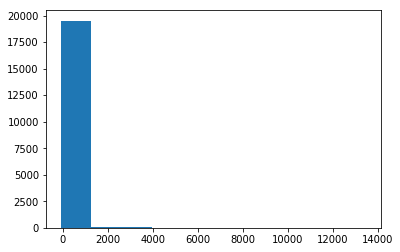

In [15]:
plt.hist(score_not_removed)

(array([1.2299e+04, 1.8000e+01, 6.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -132. ,  1637.7,  3407.4,  5177.1,  6946.8,  8716.5, 10486.2,
        12255.9, 14025.6, 15795.3, 17565. ]),
 <a list of 10 Patch objects>)

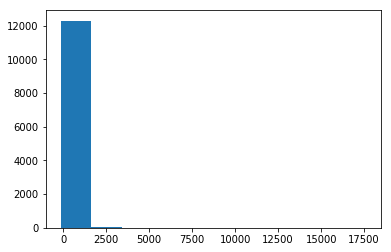

In [14]:
plt.hist(score_removed)

For now, let us only use content of the body as features for the model, since we want our model to act quickly (don't need to wait for user scores). 

In [5]:
my_train = sampled_train[['body', 'REMOVED']]
my_test = pd.read_csv('data/reddit_200k_test.csv', 
                      encoding = "ISO-8859-1")[['body', 'REMOVED']]
my_train[['REMOVED']] = (my_train[['REMOVED']] == True).astype(int)
my_test[['REMOVED']] = (my_test[['REMOVED']] == True).astype(int)
my_train.head()

/Users/TimGimi/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,body,REMOVED
0,Monday: Drug companies stock dives on good new...,1
1,Well i was wanting to get wasted tonight. Not...,0
2,New study shows 90% of the comments get remove...,1
3,'Max Planck from theÂ Institute for Cognitive ...,0
4,Its like this title was created using a rando...,1


In [9]:
my_test.head()

,body,REMOVED
0,"Hi Larpo_Nadar, your submission has been remov...",1
1,"So out of every 10,000 children with autism wh...",0
2,"When I was pregnant, I was warned against eati...",0
3,Imagine if this find was the bug that eradicat...,1
4,Is it a myth that the math says it would take ...,0


## Clean dataset of punctuations, whitespace, etc.

(TODO: May be redundant since BoW from sklearn does this for you)

In [7]:
def clean_df(df_orig):
    df = df_orig.copy()
    # Removing punctuations
    df['body'] = df['body'].str.replace('[^\w\s]','')
    # Remove digits
    df['body'] = df['body'].str.replace('\d+', '', regex=True, case=False)
    # Lower casing every words
    df['body'] = df['body'].str.lower()
    return df

my_train_cleaned = clean_df(my_train)
my_test_cleaned = clean_df(my_test)

X_train = my_train_cleaned['body']
y_train = my_train_cleaned['REMOVED']
X_test = my_test_cleaned['body']
y_test = my_test_cleaned['REMOVED']

As we can see below, the data is imbalanced. To handle this, we will use model class_weights to balance the dataset as we train.

In [8]:
print("length of X_train: ", len(X_train))
print("class balance: ", np.bincount(y_train))
print("length of X_test: ", len(X_test))
print("class balance: ", np.bincount(y_test))

length of X_train:  32000
class balance:  [19671 12329]
length of X_test:  55843
class balance:  [34565 21278]


# Baseline: Bag of Words 

### Baseline: Bag-of-Words, Logistic Regression
As a baseline, we will use CountVectorizer to create a bag of words, and use logistic regression as our linear baseline. Since we would like a balance between finding a troll and not misclassifying in this problem (want to remove most trollers but not remove too many true posts), we will use roc_auc as our scoring metric. 

In [49]:
lr = Pipeline([
     ('vect', CountVectorizer()),
     ('clf', LogisticRegressionCV(cv=5, max_iter=4000, 
                                  class_weight='balanced', penalty='l2', 
                                  scoring='roc_auc', solver = 'lbfgs'))
     ])
lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...andom_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0))])

In [51]:
# CROSS VALIDATION SCORE
cv_scores = [np.mean(x) for x in lr.steps[1][1].scores_[1]]
cv_scores = []
for i in range(len(lr.steps[1][1].scores_[1][0])):
    cv_scores.append(np.mean(lr.steps[1][1].scores_[1][:,i]))
best_cv_score=max(cv_scores)
best_cv_score

0.7048077323079116

We can see above that the cross-validation score for the baseline model is not too bad, better than random guessing (~<50% on most metrics). Now let's try to see if other variations of the model (with tfidf, n-grams, etc.) works better.

## Try using n-grams, characters, tf-idf rescaling.

### With TFIDF

From the results below, we see that TFIDF doesn't have a significant impact on the scores, compared to the baseline.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
lr_tfidf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegressionCV(cv=5, n_jobs=-1, max_iter=4000, 
                                  class_weight='balanced', penalty='l2', 
                                  scoring='roc_auc', solver = 'lbfgs'))
     ])
lr_tfidf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0))])

In [70]:
# CROSS VALIDATION SCORE
cv_scores = [np.mean(x) for x in lr_tfidf.steps[2][1].scores_[1]]
cv_scores = []
for i in range(len(lr_tfidf.steps[2][1].scores_[1][0])):
    cv_scores.append(np.mean(lr_tfidf.steps[2][1].scores_[1][:,i]))
best_cv_score=max(cv_scores)
best_cv_score

0.7135360152384247

As we can see here, our cv_scores improved by about 1%, which isn't that significant.

### With Word N-Grams

Let's now see how our model works with Word/Character N-Grams. First, let's see how our model works if we only use word n grams.

In [ ]:
text_clf_word = Pipeline([
     ('vect', CountVectorizer(analyzer='word')),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression(class_weight='balanced', 
                                penalty='l2', max_iter=4000, 
                                solver = 'lbfgs'))
     ])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7), (2, 3), (2, 5), (3, 8), (5, 5)],
    'vect__min_df': [1, 2, 3],
    'clf__C': [100, 10, 1, 1e-1, 1e-2, 1e-3]
     }

gs_clf_word = GridSearchCV(text_clf_word, parameters, 
                           cv=5, n_jobs=-1, scoring = "roc_auc")
gs_clf_word.fit(X_train, y_train)

In [73]:
# TRAIN/CROSS-VAL score
print('Best Params: ', gs_clf_word.best_params_)
print('Best: ', gs_clf_word.best_score_)

Best Params:  {'clf__C': 1, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
Best:  0.7215608461131218


Our cross validation score increased slightly again by about 1%. Next, let's see how our model works if we use character ngrams. 

### With Character N-Grams

In [ ]:
text_clf_char = Pipeline([
     ('vect', CountVectorizer(analyzer='char_wb')),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression(class_weight='balanced', 
                                penalty='l2', max_iter=4000, 
                                solver = 'lbfgs'))
     ])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7), (2, 3), (2, 5), (3, 8), (5, 5)],
    'vect__min_df': [1, 2, 3],
    'clf__C': [100, 10, 1, 1e-1, 1e-2, 1e-3]
     }

gs_clf_char = GridSearchCV(text_clf_char, parameters, 
                           cv=5, n_jobs=-1, scoring = "roc_auc")
gs_clf_char.fit(X_train, y_train)

In [78]:
# CROSS VAL SCORE
print('Best Params: ', gs_clf_char.best_params_)
print('Best: ', gs_clf_char.best_score_)

Best Params:  {'clf__C': 1, 'vect__min_df': 3, 'vect__ngram_range': (1, 7)}
Best:  0.7351486932766884


Our character n-grams improved our results even more! So we will use character n-grams in this case.

### Conclusion

As we can see above, we found that our character n-grams and tfidf improved our model from the baseline by about 3%. So we will use such settings.

## Feature Engineering
Let us now try to derive more features from this dataset (e.g. Html, length, punctuation, capitalization) to try to improve the score.

Let's see if driving additional features will improve our model.

In [80]:
train_derived = my_train.copy()

### Capitalization

#### Percentage of Capitalized Letters

In [81]:
def count_upper(sentence):
    count = 0
    for letter in sentence: 
        if letter.isupper():
            count += 1
    
    return count/len(sentence)

count_upper_v = np.vectorize(count_upper)
train_derived['capital_letter_pct'] = count_upper_v(train_derived['body'])

#### Number of All Capitalized Words

In [82]:
def count_upper_words(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    count = 0
    words = sentence.split(' ')
    for w in words:
        allcaps = True
        if w.isupper() and len(w) > 1:
            count += 1
    return count
count_upper_words_v = np.vectorize(count_upper_words)
train_derived['capital_word_count'] = count_upper_words_v(train_derived['body'])

### Length 
Next, let's count the length of the sentence itself as well as the longest word in the sentence. First, let's remove websites.

In [83]:
train_without_url = train_derived.copy()
# number of digits
train_derived['digits_count'] = train_without_url['body'].str.count('\d') 
# number of alphabets
train_derived['alphabet_count'] = train_without_url['body'].str.count('[A-Za-z]') 
train_derived['sentence_length'] = train_without_url['body'].str.len()

def longest_word_n(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split(' ')
    return max([len(w) for w in words])
longest_word_n_v = np.vectorize(longest_word_n)
train_derived['longest_word_length'] = longest_word_n_v(train_without_url['body'])

### Websites

#### Number of Links

In [84]:
train_derived['links_count'] = train_derived['body'].str.count('http')

#### Top Level Domains Count

In [85]:
top_domains = ['\.com','\.org','\.edu','\.gov','\.net','\.io']
for i in top_domains:
    colname = 'count_'+i
    train_derived[colname] = train_derived.body.str.count(i)    

### Punctuation Count

In [86]:
punctuation = ['!','\?','\.','#',':',';','@','\(','\)','\'','&','\$',';\)',':\)']
for i in punctuation:
    colname = 'count_'+i
    train_derived[colname] = train_derived.body.str.count(i)    

### Putting it Together

In [87]:
def derive_new_features(original):
    df = original.copy()
    # capital letter
    df['capital_letter_pct'] = count_upper_v(df['body'])
    df['capital_word_count'] = count_upper_words_v(df['body'])
    # websites
    df['links_count'] = df['body'].str.count('http')
    top_domains = ['\.com','\.org','\.edu','\.gov','\.net','\.io']
    for i in top_domains:
        colname = 'count_'+i
        df[colname] = df.body.str.count(i)
    # length
    df['digits_count'] = df['body'].str.count('\d')
    df['alphabet_count'] = df['body'].str.count('[A-Za-z]')
    df['sentence_length'] = df['body'].str.len()
    df['longest_word_length'] = longest_word_n_v(df['body'])
    # punctuation
    punctuation = ['!','\?','\.','#',':',';','@','\(','\)','\'','&','\$',';\)',':\)']
    for i in punctuation:
        colname = 'count_'+i
        df[colname] = df.body.str.count(i)    
    return df
train_derived = derive_new_features(my_train)

### Check Score
Let's see if these new derived features increased our classification performance.

In [89]:
X_train_derived = train_derived.drop(['REMOVED'], axis = 1)
y_train_derived = train_derived['REMOVED']

In [90]:
text_col = 'body'
others_col = list(np.delete(X_train_derived.columns.values, 0))

In [91]:
from sklearn.base import TransformerMixin
from scipy.sparse import csr_matrix

class SparseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return csr_matrix(X)

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

text_preprocess = Pipeline(steps=[
     ('vect', CountVectorizer(analyzer='char_wb')),
     ('tfidf', TfidfTransformer())
])

other_preprocess = Pipeline(steps=[
    ('sparse', SparseTransformer())
])

col_transformer = ColumnTransformer(
    [('text',text_preprocess, text_col),
    ('other',other_preprocess, others_col)]
)

final_pipeline = Pipeline(steps=[
    ('columntransformer', col_transformer),
    ('logisticregression', LogisticRegression(class_weight='balanced', 
                                              max_iter=4000, 
                                              solver = 'lbfgs'))
])

In [ ]:
parameters = {
    'columntransformer__text__vect__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7), (2, 3), (2, 5), (3, 8), (5, 5)],
    'columntransformer__text__vect__min_df': [1, 2, 3],
    'logisticregression__C': [100, 10, 1, 1e-1, 1e-2, 1e-3]
     }

gs_derived = GridSearchCV(final_pipeline, parameters, cv=5, 
                          n_jobs=-1, scoring = "roc_auc")
gs_derived.fit(X_train_derived, y_train_derived)

In [94]:
print('Best Params: ', gs_derived.best_params_)
print('Best: ', gs_derived.best_score_)

Best Params:  {'columntransformer__text__vect__min_df': 2, 'columntransformer__text__vect__ngram_range': (1, 5), 'logisticregression__C': 1}
Best:  0.7521540955881347


### Conclusion
Our derived features improves our score by yet another 1%. In this case, let's include our derived features!

# Word Vectors
Now we will try to use a pretrained word-embedding (Google News Gensim) to model our data.

In [107]:
import gensim

In [108]:
# download here https://github.com/mmihaltz/word2vec-GoogleNews-vectors
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [129]:
X_train_gensim = train_derived_clean.drop(['REMOVED'], axis = 1)
y_train_gensim = train_derived_clean['REMOVED']

### We have to remove words that are not in our dictionary and remove empty lists

In [130]:
x_train_texts = [[token for token in doc.lower().split() if token in model] \
                 for doc in X_train_gensim['body']]
index_to_remove = [len(i) for i in x_train_texts]
x_train_texts = [i for i in x_train_texts if len(i) > 0]
x_train_new = np.vstack([np.mean(model[doc], axis=0) for doc in x_train_texts])
y_index = [i != 0 for i in index_to_remove]
y_train_new = y_train_gensim[y_index]

In [135]:
X_other = X_train_gensim.drop(['body'], axis=1)[y_index]
X_train_gensim = np.concatenate((x_train_new, X_other.values), axis=1)

In [111]:
x_test_texts = [[token for token in doc.lower().split() if token in model] \
                for doc in X_test_gensim['body']]
index_to_remove = [len(i) for i in x_test_texts]
x_test_texts = [i for i in x_test_texts if len(i) > 0]
x_test_new = np.vstack([np.mean(model[doc], axis=0) for doc in x_test_texts])
y_index = [i != 0 for i in index_to_remove]
y_test_new = y_test_gensim[y_index]

### Running our w2v model

In [138]:
lr_w2v = LogisticRegressionCV(cv=5, class_weight='balanced', 
                              penalty='l2', n_jobs=-1, 
                              scoring='roc_auc', max_iter=100,
                              solver = 'lbfgs')
lr_w2v.fit(X_train_gensim, y_train_new)

/Users/TimGimi/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [143]:
# CROSS VALIDATION SCORE
cv_scores = [np.mean(x) for x in lr_w2v.scores_[1]]
cv_scores = []
for i in range(len(lr_w2v.scores_[1])):
    cv_scores.append(np.mean(lr_w2v.scores_[1][:,i]))
best_cv_score=max(cv_scores)
best_cv_score

0.7017863157479809

### Conclusion
Our word2vec model is worse by 5%! This is probably due to gensim 'playing down' the effects of mispellings due to the embeddings compared to the bag of words, which can be indicative of a troll. Therefore, we will choose our improved bag of words model as our best model. 

# Best Model : Test Score

Now that we have found our best model (bag-of-words), let's see how it performs to our out of sample dataset. 

In [175]:
test_derived = derive_new_features(my_test)
X_test_derived = test_derived.drop(['REMOVED'], axis = 1)
y_test_derived = test_derived['REMOVED']

In [177]:
y_pred = gs_derived.predict(X_test_derived)
print("Classification report: ")
print(classification_report(y_test_derived, y_pred, digits=4))
print("Confusion matrix: ")
print(pd.DataFrame(confusion_matrix(y_test_derived, y_pred)))
print("ROC-AUC Score: ")
print(roc_auc_score(y_test_derived, y_pred))

Classification report: 
              precision    recall  f1-score   support

           0     0.7937    0.6838    0.7346     34565
           1     0.5806    0.7112    0.6393     21278

   micro avg     0.6942    0.6942    0.6942     55843
   macro avg     0.6871    0.6975    0.6870     55843
weighted avg     0.7125    0.6942    0.6983     55843

Confusion matrix: 
       0      1
0  23635  10930
1   6145  15133
ROC-AUC Score: 
0.6974941176376211


Our test ROC_AUC from our model is 69.7%, which is not terrible considering our alternative is only random guessing. 

## Production Considerations

Our model is not a highly accurate model, thus if this model was to be implemented it should act as a 'flagging tool' and give human administrators the power to decide whether a post should be removed/not, rather than completely automating the removal procedure. 

## Next Steps 

We can try to improve this model by deriving/including more features (traverse the user id, score), add more computation power to be able to grid search a larger dataset, and use more advanced models/different word embeddings.